## Handwritten Digit Recognition - using MNIST dataset

### Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import keras
from keras.datasets import mnist
import copy
from collections import Counter

### Loading data

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Training features shape: {x_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {x_test.shape}")
print(f"Test target shape: {y_train.shape}")
print(f"X_train sample data: \n{x_train[0]}")
print(f"y_train[0-5]: {y_train[:5]}")

Training features shape: (60000, 28, 28)
Training target shape: (60000,)
Test features shape: (10000, 28, 28)
Test target shape: (60000,)
X_train sample data: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0

### Preprocessing - flattening (28 x 28) matrix to 784 features

In [13]:
def preprocess(x_train, x_test, y_train, y_test):
  x_train_new = []
  x_test_new = []
  nrows = len(x_train[0])
  ncols = len(x_train[0])
  max_value = 255
  for k in range(len(x_train)):
    new_row = []
    for i in range(nrows):
      for j in range(ncols):
        new_row.append(x_train[k][i][j])
    x_train_new.append(new_row)

  for k in range(len(x_test)):
    new_row = []
    for i in range(nrows):
      for j in range(ncols):
        new_row.append(x_test[k][i][j])
    x_test_new.append(new_row)
  x_train_new = np.array(x_train_new) / max_value
  x_test_new = np.array(x_test_new) / max_value
  print(x_train_new.shape)
  print(x_test_new.shape)
  return x_train_new, x_test_new, y_train, y_test
x_train_new, x_test_new, y_train_new, y_test_new = preprocess(x_train, x_test, y_train, y_test)

(60000, 784)
(10000, 784)


### Utility functions

In [14]:
def confusion_matrix(y_test, y_pred, num_classes = 10):
  matrix = np.zeros((num_classes, num_classes))
  labels = range(10)
  for i in range(len(y_test)):
    if(y_test[i] == y_pred[i]):
      matrix[y_test[i]][y_test[i]] += 1
    else:
      matrix[y_test[i]][y_pred[i]] += 1
  return pd.DataFrame(matrix, index = labels, columns = labels, dtype = 'int64')

def get_results(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  acc_score = accuracy_score(y_test, y_pred)
  print("Confusion Matrix: ")
  print(cm)
  print("Accuracy Score: ")
  print(acc_score)
  print("\n")
  precision = np.zeros(num_classes)
  recall = np.zeros(num_classes)
  f1_score = np.zeros(num_classes)
  matrix = confusion_matrix(y_test, y_pred)
  for j in range(num_classes):
    precision[j] = matrix[j][j] / matrix.loc[:, j].sum()
  for i in range(num_classes):
    recall[i] = matrix[i][i] / matrix.loc[i, :].sum()
  for i in range(num_classes):
    f1_score[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
    print(f"Class {i} - precision: {precision[i]}, recall: {recall[i]}, F1-score: {f1_score[i]}")
  return acc_score

### Implementing Multinomial Logistic Regression (using softmax)

In [15]:
class MultinomialLogisticRegression:

  def __init__(self, num_features, num_classes, learning_rate=0.01, epochs=1000):
      self.num_features = num_features
      self.num_classes = num_classes
      self.learning_rate = learning_rate
      self.epochs = epochs
      self.W = np.random.randn(num_features, num_classes) * 0.01
      self.b = np.zeros((1, num_classes))

  def softmax(self, z):
    z_max = np.max(z, axis = 1, keepdims = True)
    exp_z = np.exp(z - z_max)
    return exp_z / np.sum(exp_z, axis = 1, keepdims = True)

  def cross_entropy_loss(self, y, y_pred):
    m = y.shape[0]
    y_pred_log = np.log(y_pred + 1e-10)
    return -np.sum(y * y_pred_log) / m

  def one_hot_encode(self, y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

  def fit(self, X, y):
    m = X.shape[0]
    Y = self.one_hot_encode(y, self.num_classes)
    loss_history = []
    epoch_history = []
    for epoch in range(self.epochs):
      z = np.dot(X, self.W) + self.b
      y_pred = self.softmax(z)
      loss = self.cross_entropy_loss(Y, y_pred)
      if(epoch % 100 == 0):
        print(f"Epoch: {epoch},  Loss: {loss:.4f}")
        epoch_history.append(epoch)
        loss_history.append(loss)
      error = y_pred - Y
      dj_dw = np.dot(X.T, error) / m
      dj_db = np.sum(error, axis = 0, keepdims = True) / m
      self.W -= self.learning_rate * dj_dw
      self.b -= self.learning_rate * dj_db
    return epoch_history, loss_history

  def predict(self, X):
    z = np.dot(X, self.W) + self.b
    y_pred = self.softmax(z)
    return np.argmax(y_pred, axis = 1)

  def predict_prob(self, X):
    z = np.dot(X, self.W) + self.b
    return self.softmax(z)

In [16]:
np.random.seed(42)
num_samples = x_train_new.shape[0]
num_features = x_train_new.shape[1]
num_classes = 10

model = MultinomialLogisticRegression(num_features, num_classes, learning_rate=0.1, epochs=500)
epochs, losses = model.fit(x_train_new, y_train_new)

Epoch: 0,  Loss: 2.3277
Epoch: 100,  Loss: 0.6104
Epoch: 200,  Loss: 0.4903
Epoch: 300,  Loss: 0.4411
Epoch: 400,  Loss: 0.4127


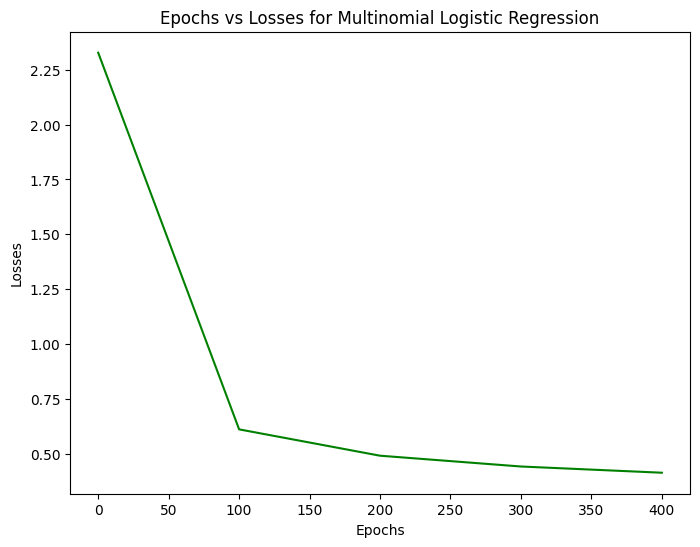

In [17]:
plt.figure(figsize = (8, 6))
plt.plot(epochs, losses, c = 'green')
plt.title('Epochs vs Losses for Multinomial Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

In [18]:
y_pred_logistic_multi = model.predict(x_test_new)
get_results(y_test_new, y_pred_logistic_multi)

Confusion Matrix: 
     0     1    2    3    4    5    6    7    8    9
0  957     0    3    3    0    1    9    1    6    0
1    0  1103    2    4    1    2    4    0   19    0
2   11     7  888   20   15    0   17   21   44    9
3    5     1   19  900    1   30    5   15   22   12
4    1     6    5    1  902    1   12    2    8   44
5   15     6    5   42   15  734   17   10   37   11
6   16     3    7    2   14   17  894    1    4    0
7    3    19   30    4   11    0    0  917    4   40
8    9    10   10   30    8   29   12   13  836   17
9   12     8    6    9   47   16    0   24    7  880
Accuracy Score: 
0.9011


Class 0 - precision: 0.9300291545189504, recall: 0.976530612244898, F1-score: 0.9527127924340467
Class 1 - precision: 0.9484092863284609, recall: 0.9718061674008811, F1-score: 0.9599651871192342
Class 2 - precision: 0.9107692307692308, recall: 0.8604651162790697, F1-score: 0.8849028400597908
Class 3 - precision: 0.8866995073891626, recall: 0.8910891089108911, F1-score: 

0.9011

### Using Library to implement Logistic Regression

In [19]:
def build_logistic_regression(x_train, y_train):
  classifier = LogisticRegression(random_state = 0)
  classifier.fit(x_train_new, y_train)
  return classifier

logistic_classifier = build_logistic_regression(x_train_new, y_train_new)
y_pred_logistic = logistic_classifier.predict(x_test_new)
logistic_score = get_results(y_test_new, y_pred_logistic)

Confusion Matrix: 
     0     1    2    3    4    5    6    7    8    9
0  959     0    0    3    1    7    5    4    1    0
1    0  1111    4    2    0    2    3    2   11    0
2    6     9  926   16    9    4   13    6   39    4
3    4     1   18  917    1   22    4   11   25    7
4    1     1    7    3  914    0   10    4   10   32
5   10     2    3   34    7  783   14    6   29    4
6    9     3    8    2    7   14  912    2    1    0
7    1     8   24    5    7    1    0  950    3   29
8    9    11    8   23    7   25   12    7  860   12
9    9     8    0   11   24    6    0   19    7  925
Accuracy Score: 
0.9257


Class 0 - precision: 0.9513888888888888, recall: 0.9785714285714285, F1-score: 0.9647887323943661
Class 1 - precision: 0.962738301559792, recall: 0.9788546255506608, F1-score: 0.9707295762341633
Class 2 - precision: 0.9278557114228457, recall: 0.8972868217054264, F1-score: 0.9123152709359605
Class 3 - precision: 0.9025590551181102, recall: 0.907920792079208, F1-score: 0

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Implementing K-nearest-neighbors

In [20]:
class KNN:
  def __init__(self, k = 5):
    self.k = k

  def euclidean_distance(self, x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

  def fit(self, x, y):
    self.x_train = x
    self.y_train = y

  def predict(self, x):
    predictions = [self.predict_single(x_i) for x_i in x]
    return np.array(predictions)

  def predict_single(self, x):
    distances = [self.euclidean_distance(x, x_train_i) for x_train_i in self.x_train]
    k_indices = np.argsort(distances)[:self.k]
    k_nearest_labels = [self.y_train[i] for i in k_indices]
    most_common = Counter(k_nearest_labels).most_common(1)
    return most_common[0][0]

  def predict_prob(self, x):
    probabilities = []
    for x_i in x:
      distances = [self.euclidean_distance(x_i, x_train_i) for x_train_i in self.x_train]
      k_indices = np.argsort(distances)[:self.k]
      k_nearest_labels = [self.y_train[i] for i in k_indices]
      class_counts = Counter(k_nearest_labels)
      prob = np.zeros(10)
      for cls in class_counts:
        prob[cls] = class_counts[cls] / self.k
      probabilities.append(prob)
    return np.array(probabilities)

In [21]:
# Using m/100 data to reduce training time
m = x_train.shape[0] / 100
n = x_train.shape[1]
num_classes = 10

knn = KNN(k=5)
knn.fit(x_train_new[:600], y_train_new[:600])

predictions = knn.predict(x_test_new[:100])
probabilities = knn.predict_prob(x_test_new[100])

print("Predictions:", predictions)
print("Probabilities:\n", probabilities)

accuracy = np.mean(predictions == y_test_new[:100])
print("Accuracy:", accuracy)

Predictions: [7 2 1 0 4 1 9 9 4 7 0 6 9 0 1 3 9 7 3 4 9 6 6 5 4 0 9 4 0 1 3 1 3 4 7 2 7
 1 1 1 1 7 4 1 1 5 1 2 4 4 6 3 5 5 0 0 4 1 9 1 7 2 9 9 7 9 2 4 3 0 7 0 2 9
 1 7 3 7 9 7 9 6 2 9 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]
Probabilities:
 [[0.  0.8 0.  ... 0.  0.2 0. ]
 [0.  0.8 0.  ... 0.  0.2 0. ]
 [0.  0.8 0.  ... 0.  0.2 0. ]
 ...
 [0.  0.8 0.  ... 0.  0.2 0. ]
 [0.  0.8 0.  ... 0.  0.2 0. ]
 [0.  0.8 0.  ... 0.  0.2 0. ]]
Accuracy: 0.83


### Using Library to implement K-nearest-neighbor

In [22]:
def build_knn_classifier(X_train, y_train):
  classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean', p = 2)
  classifier.fit(X_train, y_train)
  return classifier
knn_classifier = build_knn_classifier(x_train_new, y_train_new)
y_pred_knn = knn_classifier.predict(x_test_new)
knn_score = get_results(y_test_new, y_pred_knn)

Confusion Matrix: 
     0     1    2    3    4    5    6    7    8    9
0  974     1    1    0    0    1    2    1    0    0
1    0  1133    2    0    0    0    0    0    0    0
2   11     8  991    2    1    0    1   15    3    0
3    0     3    3  976    1   13    1    6    3    4
4    3     7    0    0  944    0    4    2    1   21
5    5     0    0   12    2  862    4    1    2    4
6    5     3    0    0    3    2  945    0    0    0
7    0    22    4    0    3    0    0  988    0   11
8    8     3    5   13    6   12    5    5  913    4
9    5     7    3    9    7    3    1   10    2  962
Accuracy Score: 
0.9688


Class 0 - precision: 0.963402571711177, recall: 0.9938775510204082, F1-score: 0.9784028126569563
Class 1 - precision: 0.9545071609098568, recall: 0.9982378854625551, F1-score: 0.9758828596037898
Class 2 - precision: 0.9821605550049554, recall: 0.9602713178294574, F1-score: 0.9710926016658501
Class 3 - precision: 0.9644268774703557, recall: 0.9663366336633663, F1-score: 

### Using Library to implement Random Forest

In [23]:
def build_random_forest_classifier(X_train, y_train):
  classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
  classifier.fit(X_train, y_train)
  return classifier

rf_classifier = build_random_forest_classifier(x_train_new, y_train_new)
y_pred_rf = rf_classifier.predict(x_test_new)
rf_score = get_results(y_test_new, y_pred_rf)

Confusion Matrix: 
     0     1    2    3    4    5    6    7    8    9
0  969     0    0    0    0    3    3    1    3    1
1    0  1122    3    3    0    3    2    1    1    0
2    7     0  999    6    3    0    4    9    4    0
3    0     0   10  972    0    6    0    9    8    5
4    1     0    1    0  958    0    4    1    4   13
5    3     0    0   10    2  862    8    1    5    1
6    6     3    0    0    5    4  936    0    4    0
7    1     6   21    2    0    0    0  987    3    8
8    5     0    5    4    3    8    3    4  931   11
9    8     6    1   13   13    3    1    3    5  956
Accuracy Score: 
0.9692


Class 0 - precision: 0.969, recall: 0.9887755102040816, F1-score: 0.9787878787878789
Class 1 - precision: 0.9868073878627969, recall: 0.9885462555066079, F1-score: 0.9876760563380281
Class 2 - precision: 0.9605769230769231, recall: 0.9680232558139535, F1-score: 0.9642857142857144
Class 3 - precision: 0.9623762376237623, recall: 0.9623762376237623, F1-score: 0.9623762376